## Fosberg Fire Weather Index

This notebook briefly walks through how to calculate the wildfire metric `change in annual median # of days with FFWI greater than 50` from Cal-Adapt: Analytics Engine data. This notebook may be expanded upon for inclusion in cae-notebooks in the future. 

**Order of operations**:
1. Read data in
2. Calculate delta signal
3. Reprojection to census tracts
4. Min-max standardization
5. Export data
6. Generate metadata (via Cal-CRAI environment, not AE)

### Step 0: Import libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import pyproj
import rioxarray as rio
import xarray as xr
# projection information
import cartopy.crs as ccrs
crs = ccrs.LambertConformal(
    central_longitude=-70, 
    central_latitude=38, 
    false_easting=0.0, 
    false_northing=0.0,  
    standard_parallels=[30, 60], 
    globe=None,
)

import os
import sys
sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import upload_csv_aws, pull_nc_from_directory
from scripts.utils.write_metadata import append_metadata

In [2]:
def reproject_to_tracts(ds_delta, ca_boundaries):
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x,df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)
    
    ca_boundaries = ca_boundaries.set_index(['GEOID'])
    
    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how='left')
    clipped_gdf = clipped_gdf.drop(['index_right'], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[
        ["GEOID",f"{ds_delta.name}","geometry"]]
    ### some coastal tracts do not contain any land grid cells ###
    ### due to the WRF's underlying surface type for a given grid cell. ###
    
    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(
        by='GEOID', aggfunc='mean')
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right":
                 ds_delta.name}
    )
    
    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_nan = clipped_gdf_nan[["geometry",ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_valid = clipped_gdf_valid[["geometry",ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")
    
    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how='left')
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left",f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(columns={
        "geometry_left":"geometry", f"{ds_delta.name}_right":ds_delta.name
    })
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")
 
    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid,clipped_gdf_filled])

    return gdf_all_tracts

def min_max_standardize(df, col):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    max_value = df[col].max()
    min_value = df[col].min()

    # Get min-max values, standardize, and add columns to df
    prefix = col # Extracting the prefix from the column name
    df[f'{prefix}_min'] = min_value
    df[f'{prefix}_max'] = max_value
    df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))

    # checker to make sure new min_max column values arent < 0 > 1
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] < 0] = 0
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] > 1] = 1

    # Drop the original columns -- we want to keep as a check
    # df = df.drop(columns=[col])
     
    return df

### Step 1: Read in intermediary files
These files were generated via the `climate_ae_wildfire_intermediary_data_generation.ipynb` notebook on the Analytics Engine. 

In [3]:
# historical baseline (1981-2010) data
# download intermediary files
pull_nc_from_directory("2a_subset/climate_risk/wildfire/exposure/ffwi_hist_9km.nc", "ffwi_hist_9km.nc")

# open files
ds_hist = xr.open_dataset('ffwi_hist_9km.nc')
ds_hist

2a_subset/climate_risk/wildfire/exposure/ffwi_hist_9km.nc downloaded!


<xarray.Dataset>
Dimensions:                     (y: 144, x: 60)
Coordinates:
    Lambert_Conformal           int64 ...
    lakemask                    (y, x) float32 ...
    landmask                    (y, x) float32 ...
    lat                         (y, x) float32 ...
    lon                         (y, x) float32 ...
    scenario                    object ...
  * x                           (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                           (y) float64 5.479e+05 5.569e+05 ... 1.835e+06
Data variables:
    Fosberg fire weather index  (y, x) float64 ...

In [4]:
# 2degC WL data -- each model is stored in a separate file
# download intermediary files
pull_nc_from_directory("2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_ECEarth3.nc", "ffwi_proj_9km_ECEarth3.nc")
pull_nc_from_directory("2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_MIROC.nc", "ffwi_proj_9km_MIROC.nc")
pull_nc_from_directory("2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_MPI.nc", "ffwi_proj_9km_MPI.nc")
pull_nc_from_directory("2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_TaiESM.nc", "ffwi_proj_9km_TaiESM.nc")

# open files
ds_proj_sim1 = xr.open_dataset('ffwi_proj_9km_ECEarth3.nc')
ds_proj_sim2 = xr.open_dataset('ffwi_proj_9km_MIROC.nc')
ds_proj_sim3 = xr.open_dataset('ffwi_proj_9km_MPI.nc')
ds_proj_sim4 = xr.open_dataset('ffwi_proj_9km_TaiESM.nc')

2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_ECEarth3.nc downloaded!
2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_MIROC.nc downloaded!
2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_MPI.nc downloaded!
2a_subset/climate_risk/wildfire/exposure/ffwi_proj_9km_TaiESM.nc downloaded!


In [5]:
# merge all 4 simulations into a single dataset on a new dimension "simulation"
ds_proj = xr.concat([ds_proj_sim1, ds_proj_sim2, ds_proj_sim3, ds_proj_sim4], dim='simulation')
ds_proj

<xarray.Dataset>
Dimensions:                     (simulation: 4, y: 144, x: 60)
Coordinates:
    Lambert_Conformal           int64 0
    lakemask                    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    landmask                    (y, x) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    lat                         (y, x) float32 30.96 31.01 31.05 ... 43.39 43.44
    lon                         (y, x) float32 -117.9 -117.8 ... -121.6 -121.5
    scenario                    <U43 'Historical + SSP 3-7.0 -- Business as U...
  * simulation                  (simulation) <U26 'WRF_EC-Earth3_r1i1p1f1' .....
  * x                           (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                           (y) float64 5.479e+05 5.569e+05 ... 1.835e+06
Data variables:
    Fosberg fire weather index  (simulation, y, x) float64 0.0 0.0 ... 0.0 0.0

In [6]:
# reduce and calculate metric
ds_proj = ds_proj.mean(['simulation'])
ds_proj

<xarray.Dataset>
Dimensions:                     (y: 144, x: 60)
Coordinates:
    Lambert_Conformal           int64 0
    lakemask                    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    landmask                    (y, x) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    lat                         (y, x) float32 30.96 31.01 31.05 ... 43.39 43.44
    lon                         (y, x) float32 -117.9 -117.8 ... -121.6 -121.5
    scenario                    <U43 'Historical + SSP 3-7.0 -- Business as U...
  * x                           (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                           (y) float64 5.479e+05 5.569e+05 ... 1.835e+06
Data variables:
    Fosberg fire weather index  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

### Step 2: Calculate delta signal

In [7]:
ds_delta = ds_proj - ds_hist
ds_delta = ds_delta['Fosberg fire weather index'] 
ds_delta.name = 'change_ffwi_days'

In [8]:
ds_delta.min().values, ds_delta.max().values, ds_delta.mean().values

(array(-9.68333333), array(5.9), array(-0.49168596))

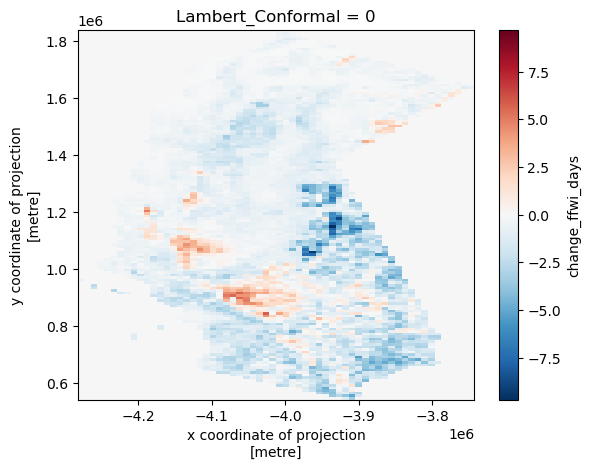

In [9]:
ds_delta.plot()

### Step 3: Reproject to census tract boundaries

In [10]:
# load in census tract shapefile
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/" # pulling from AWS
# census_shp_dir = "2021_ca_tract/tl_2021_06_tract.shp" # local run, requires having census tracts loaded in file tree

ca_boundaries = gpd.read_file(census_shp_dir)

In [11]:
# convert to area-preserving CRS
ca_boundaries = ca_boundaries.to_crs(crs=3310)
ffwi_df = reproject_to_tracts(ds_delta, ca_boundaries)
ffwi_df

,geometry,change_ffwi_days
GEOID,,
06001400100,"POLYGON ((-197333.073 -12225.563, -197310.342 ...",0.000000
06001400200,"POLYGON ((-198413.266 -16953.512, -198395.570 ...",0.000000
06001400300,"POLYGON ((-199103.674 -17489.695, -199097.315 ...",0.000000
06001400400,"POLYGON ((-198758.781 -17054.583, -198756.493 ...",0.000000
06001400500,"POLYGON ((-199415.107 -16265.064, -199403.023 ...",0.000000
...,...,...
06115040902,"POLYGON ((-127581.030 125152.281, -127551.655 ...",-1.183333
06115041001,"POLYGON ((-141093.293 138062.571, -141093.000 ...",-1.777083
06115041002,"POLYGON ((-126526.366 147414.627, -126495.726 ...",-1.762500


## Fixing header output

In [16]:
# Create a new DataFrame with the desired columns
new_columns = ['GEOID', 'geometry', 'change_ffwi_days']
ffwi_df_cleaned = pd.DataFrame(columns=new_columns)

ffwi_df_reset = ffwi_df.reset_index()

# Populate the new DataFrame with data from the existing one
ffwi_df_cleaned['GEOID'] = ffwi_df.index  # Get GEOID from the index
ffwi_df_cleaned['geometry'] = ffwi_df_reset['geometry']  # Get geometry column
ffwi_df_cleaned['change_ffwi_days'] = ffwi_df_reset['change_ffwi_days']  # Get change_ffwi_days column

# Check the new DataFrame
ffwi_df_cleaned

,GEOID,geometry,change_ffwi_days
0,06001400100,"POLYGON ((-197333.073 -12225.563, -197310.342 ...",0.000000
1,06001400200,"POLYGON ((-198413.266 -16953.512, -198395.570 ...",0.000000
2,06001400300,"POLYGON ((-199103.674 -17489.695, -199097.315 ...",0.000000
3,06001400400,"POLYGON ((-198758.781 -17054.583, -198756.493 ...",0.000000
4,06001400500,"POLYGON ((-199415.107 -16265.064, -199403.023 ...",0.000000
...,...,...,...
9124,06115040902,"POLYGON ((-127581.030 125152.281, -127551.655 ...",-1.183333
9125,06115041001,"POLYGON ((-141093.293 138062.571, -141093.000 ...",-1.777083
9126,06115041002,"POLYGON ((-126526.366 147414.627, -126495.726 ...",-1.762500
9127,06115041101,"POLYGON ((-118092.180 151860.378, -118035.180 ...",-0.556944


### Step 4: Min-max standardization

In [17]:
## min-max standardization
data_std = min_max_standardize(ffwi_df_cleaned, col='change_ffwi_days')

C:\Users\jesse\AppData\Local\Temp\ipykernel_17716\1326932513.py:77: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] < 0] = 0
C:\Users\jesse\AppData\Local\Temp\ipyker

### Step 5: Export final data as csv

In [18]:
# Data will be exported via pcluster run
# clean up dataframes prior to export
data_std = data_std.drop(columns=['geometry'])

In [19]:
data_std

,GEOID,change_ffwi_days,change_ffwi_days_min,change_ffwi_days_max,change_ffwi_days_min_max_standardized
0,06001400100,0.000000,-7.866667,5.9,0.571429
1,06001400200,0.000000,-7.866667,5.9,0.571429
2,06001400300,0.000000,-7.866667,5.9,0.571429
3,06001400400,0.000000,-7.866667,5.9,0.571429
4,06001400500,0.000000,-7.866667,5.9,0.571429
...,...,...,...,...,...
9124,06115040902,-1.183333,-7.866667,5.9,0.485472
9125,06115041001,-1.777083,-7.866667,5.9,0.442343
9126,06115041002,-1.762500,-7.866667,5.9,0.443402
9127,06115041101,-0.556944,-7.866667,5.9,0.530973


In [20]:
# export
metric_fname = 'climate_wildfire_ffwi_metric.csv'
data_std.to_csv(metric_fname, index=False)

### Step 6: Metadata generation

In [21]:
@append_metadata
def wildfire_ffwi_process(input_csv, export=False, varname=''):
    '''
    Reduces the size of the initial daily raw temperature data in order to streamline compute time.
    Transforms the raw data into the following baseline metrics:
    * change in median annual # of days with Fosberg Fire Weather index value >50
    
    Methods
    -------
    Metric is calculated with the FFWI threshold of 50 (indicating a moderate risk day).
    
    Parameters
    ----------
    df: pd.DataFrame
        Input data.
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI wildfire metric to AWS
        True = will upload resulting df containing CAL CRAI wildfire metric to AWS
    export_filename: string
        name of csv file to be uploaded to AWS
    varname: string
        Final metric name, for metadata generation
        
    Script
    ------
    Intermediary file generation: climate_ae_wildfire_intermediary_data_generation.ipynb
    Metric calculation: climate_ae_wildfire_metrics.ipynb
    
    Note
    ----
    Because the climate projections data is on the order of 2.4 TB in size, intermediary
    processed files are not produced for each stage of the metric calculation. All processing
    occurs in a single complete run in the notebook listed above.
    '''
         
    # calculate chronic with 2°C WL
    print('Data transformation: raw projections data retrieved for warming level of 2.0°C, by manually subsetting based on GWL for parent GCM and calculating 30 year average.')
    print("Data transformation: dynamically-downscaled climate data subsetted for a-priori bias-corrected models.")
    print("Data transformation: drop all singleton dimensions (scenario).")

    # calculate historical baseline
    print("Data transformation: historical baseline data retrieved for 1981-2010, averaging across models.")
    print("Data transformation: dynamically-downscaled climate data subsetted for a-priori bias-corrected models.")
    print("Data transformation: drop all singleton dimensions (scenario).")
    
    # calculate delta signal       
    print("Data transformation: number of median annual days calculated by summing the number of days per year above 50 threshold.")
    print("Data transformation: intermediary files generated of calculated metric data, due to size of input data.")
    print("Data transformation: delta signal calculated by taking difference between chronic (2.0°C) and historical baseline.")

    # reprojection to census tracts
    print("Data transformation: data transformed from xarray dataset into pandas dataframe.")
    print("Data transformation: data reprojected from Lambert Conformal Conic CRS to CRS 3857.")
    print("Data transformation: data infilling for coastal census tracts by the average of nearest valid census tract via sjoin.nearest") ## confirm
        
    # min-max standardization
    print("Data transformation: data min-max standardized with min_max_standardize function.")
    
    # export data as csv
    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)
    
    if export == False:
        print(f'{input_csv} uploaded to AWS.')
        
    if os.path.exists(input_csv):
        os.remove(input_csv)

In [22]:
input_csv = 'climate_wildfire_ffwi_metric.csv'
varname = 'climate_caladapt_wildfire_ffwi'
wildfire_ffwi_process(input_csv, export=True, varname='test') # varname)